# ObjectDetection and KeypointsDetection
In this demo, we will go through a sample project to show how to build a project by applying **`ObjectDetection`** and **`KeypointsDetection`** Tempaltes. 

In [1]:
import esppy
esp = esppy.ESP('<server>:<port>')

## Part 1: Linear Keypoints Detection Project
In this part, a linear keypoint detection project will be showed by applying `Temaplate`. 

In [2]:
proj = esp.create_project('LinearKeypointsDetection')
esppy.options.display.image_scale = 0.65

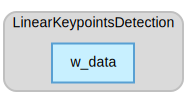

In [3]:
# Create a source window object

src = esp.SourceWindow(schema=('id*:int64', '_image_:blob'), index_type='empty', insert_only=True)
src.add_connector('fs', 'publisher', 'pub', fstype='csv', fsname='encoded_images_v4.csv', transactional=True, 
                  rate=10, repeatcount=1000, blocksize=1)

# add it to current project
proj.windows['w_data'] = src
proj

The **`ObjectDetection`** Template contains three windows:
1. A caculate window imeplementing ImageProcessing algorithm to resize the input image
2. A ModelReader window to import pretrained astore
3. A Score window to score input data on the model from astore file to get cordinates of objects in the image

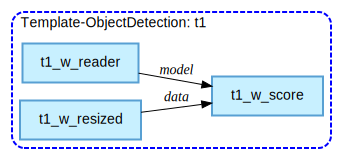

In [4]:
# Initilize a ObjectDetection template and set corresponding parameters

t1 = esp.Template.ObjectDetection('t1', astore='t1.astore', device_index=0, enable_gpu=1) # use gpu for object scoring
t1.to_graph(detail=True)

In [5]:
t1.required_parameter_map

defaultdict(list,
            {'astore': ['w_reader.reference'],
             'device_index': ['w_reader.DEVICE0'],
             'enable_gpu': ['w_reader.usegpuesp']})

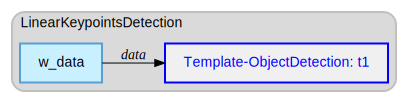

In [6]:
# Add edge between source window and template t1

src.add_target(t1, role='data') # default to add the first input_windows of t1 as a target of src
proj.add_template(t1)
proj

After identifying the object, we should **crop** it of the image. And here we make it with the help of a python fucntion. So before we start to build the KeypointDetection pipeline, a few windows are needed to complete the process.

In [7]:
# First, we need a Functional window to cast blob image type to string to be applied to the python crop function

func1 = esp.FunctionalWindow(schema=('id*:int32', '_image_:string', '_nObjects_*:double', 
                                     '_Object0_:string', '_P_Object0_:double', '_Object0_x:double', 
                                     '_Object0_y:double', '_Object0_width:double','_Object0_height:double',
                                    '_Object1_:string', '_P_Object1_:double', '_Object1_x:double', 
                                     '_Object1_y:double', '_Object1_width:double','_Object1_height:double',
                                    '_Object2_:string', '_P_Object2_:double', '_Object2_x:double', 
                                     '_Object2_y:double', '_Object2_width:double','_Object2_height:double',
                                    '_Object3_:string', '_P_Object3_:double', '_Object3_x:double', 
                                     '_Object3_y:double', '_Object3_width:double','_Object3_height:double'), 
                            index_type='empty', name='w_func1')
func1.set_function_context_functions(_image_='base64EncodeBinary($_image_)')

In [8]:
# Then, we need a Calculate window to complete the crop step

wpython = esp.PythonHelper(schema=('id*:int32', 'board_id*:int64', 'rx_min:double', 'rx_max:double', 
                                     'ry_min:double', 'ry_max:double', '_image_:string', '_board_image_:string'),
                           index_type='empty', name='w_python')
wpython.add_mas_info('module_1', 'get_all_crops_from_bbox', 'w_func1', code_file='./crop.py')

In [9]:
# Next, We need another Functional window to cast string image type to blob to be applied to KeypointDetection pipeline

func2 = esp.FunctionalWindow(schema=('id*:int32', 'board_id*:int64', 'rx_min:double', 'rx_max:double', 
                                     'ry_min:double', 'ry_max:double', '_image_:blob', '_board_image_:blob'), 
                            index_type='empty', name='w_func2')
func2.set_function_context_functions(_image_='base64DecodeBinary($_image_)', 
                                    _board_image_='base64DecodeBinary($_board_image_)')

In [10]:
# Add the windows to project
proj.windows['w_func1'] = func1
proj.windows['w_python'] = wpython
proj.windows['w_func2'] = func2

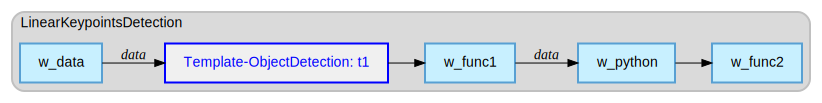

In [11]:
# Add corresponding connectivities

t1.add_target(func1)  # default to add func1 as a target of the first output_windows of template t1
func1.add_target(wpython, role='data')
wpython.add_target(func2)
esppy.options.display.image_scale = 0.65
proj

Now, we can start to build the **`KeypointDetection`** pipeline, which is very similar to object detection:
1. A caculate window imeplementing ImageProjcessing algorithm to resize the input image
2. A ModelReader window to import pretrained astore
3. A Score window to score input data on the model from astore file to get the keypoint of objects

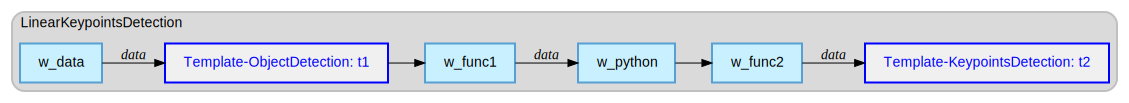

In [12]:
# Initilize a KeypointDetection template and set corresponding parameters

t2 = esp.Template.KeypointsDetection('t2', astore='t2.astore', device_index=1, enable_gpu=1)

func2.add_target(t2, role='data')  # default to add the first input_windows of t2 as a target of func2
proj.add_template(t2)
esppy.options.display.image_scale = 0.55
# proj.to_graph(template_detail=True)
proj

## Part 2: A Net-like Project
In the second part, we will build a more complex project by applying Template. Instead of applying the processed data of **w_func2** to a single KeypointDetection pipeline, multiple KeypointDetection pipelines are connected. Thus resulting in a complex `net-like` structure.

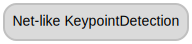

In [13]:
# Create a project 

proj2 = esp.create_project('Net-like KeypointDetection')
esppy.options.display.image_scale = 1
proj2

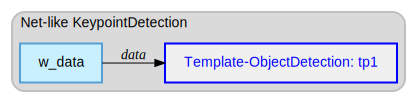

In [14]:
# Create a source window object

src2 = esp.SourceWindow(schema=('id*:int64', '_image_:blob'), index_type='empty', insert_only=True)
src2.add_connector('fs', 'publisher', 'pub', fstype='csv', fsname='encoded_images_v4.csv', transactional=True, 
                  rate=10, repeatcount=1000, blocksize=1)

# Initilize a ObjectDetection template and set corresponding parameters

tp1 = esp.Template.ObjectDetection('tp1', astore='tp1.astore', enable_gpu=0) # just use cpu
src2.add_target(tp1, role='data')

proj2.add_template(tp1)
proj2.windows['w_data']=src2
proj2

In [15]:
# Create a Functional window to cast blob image type to string

f1 = esp.FunctionalWindow(schema=('id*:int32', '_image_:string', '_nObjects_*:double', 
                                     '_Object0_:string', '_P_Object0_:double', '_Object0_x:double', 
                                     '_Object0_y:double', '_Object0_width:double', '_Object0_height:double',
                                    '_Object1_:string', '_P_Object1_:double', '_Object1_x:double', 
                                     '_Object1_y:double', '_Object1_width:double', '_Object1_height:double',
                                    '_Object2_:string', '_P_Object2_:double', '_Object2_x:double', 
                                     '_Object2_y:double', '_Object2_width:double', '_Object2_height:double',
                                    '_Object3_:string', '_P_Object3_:double', '_Object3_x:double', 
                                     '_Object3_y:double', '_Object3_width:double', '_Object3_height:double'), 
                            index_type='empty', name='w_func1')
f1.set_function_context_functions(_image_='base64EncodeBinary($_image_)')


# Create a Calculate window to crop the object
w_python = esp.PythonHelper(schema=('id*:int32', 'board_id*:int64', 'rx_min:double', 'rx_max:double', 
                                     'ry_min:double', 'ry_max:double', '_image_:string', '_board_image_:string'),
                           index_type='empty', name='w_python')
w_python.add_mas_info('module_1', 'get_all_crops_from_bbox', 'w_func1', code_file='./crop.py')


# Create another Functional window to cast string image type to blob

f2 = esp.FunctionalWindow(schema=('id*:int32', 'board_id*:int64', 'rx_min:double', 'rx_max:double', 
                                     'ry_min:double', 'ry_max:double', '_image_:blob', '_board_image_:blob'), 
                            index_type='empty', name='w_func2')
f2.set_function_context_functions(_image_='base64DecodeBinary($_image_)', 
                                    _board_image_='base64DecodeBinary($_board_image_)')

## Set splittter for following multiple KeypointDetection pipelines ##
f2.set_splitter_expr('id%4')

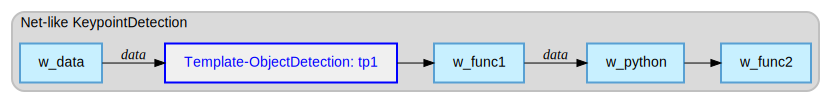

In [18]:
# Add the windows to project
proj2.windows['w_func1'] = f1
proj2.windows['w_python'] = w_python
proj2.windows['w_func2'] = f2

# Add corresponding connectivities
tp1.add_target(f1)
f1.add_target(w_python, role='data')
w_python.add_target(f2)
esppy.options.display.image_scale = 0.65
proj2

In [19]:
# Initialize multiple KeypointDetection templates
tp2 = esp.Template.KeypointsDetection('tp2', astore='tp2.astore', enable_gpu=0)
tp3 = esp.Template.KeypointsDetection('tp3', astore='tp3.astore', enable_gpu=0)
tp4 = esp.Template.KeypointsDetection('tp4', astore='tp4.astore', enable_gpu=0)
tp5 = esp.Template.KeypointsDetection('tp5', astore='tp5.astore', enable_gpu=0)

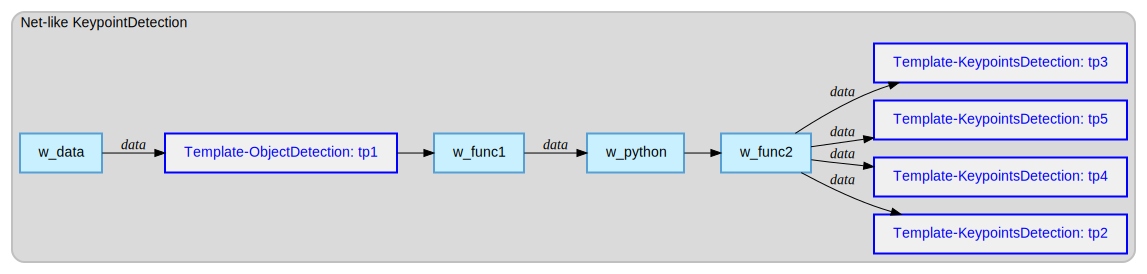

In [20]:
# Set corresponding connectivities for each template
f2.add_target(tp2, role='data', slot='0')
f2.add_target(tp3, role='data', slot='1')
f2.add_target(tp4, role='data', slot='2')
f2.add_target(tp5, role='data', slot='3')  
proj2.add_templates(tp2, tp3, tp4, tp5)
esppy.options.display.image_scale = 0.55
proj2

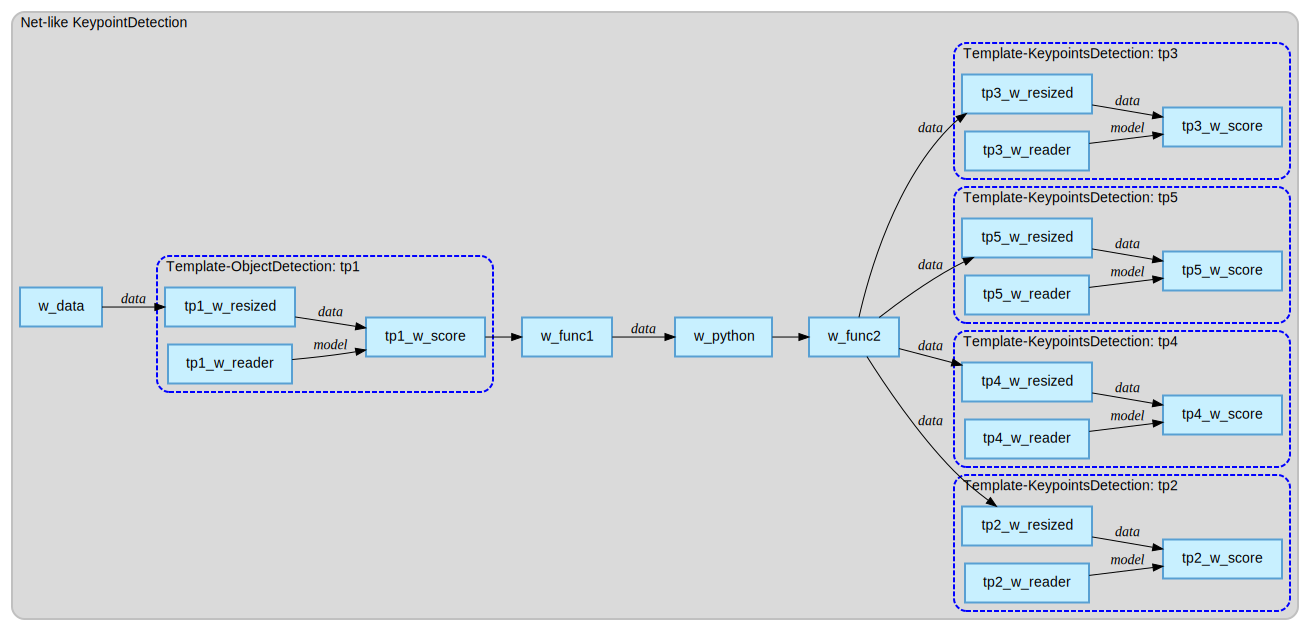

In [21]:
proj2.to_graph(template_detail=True)